In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io
import sys
sys.path.append('..')
import train.utils as utils
#from train.utils import kge,time_to_seconds,interp1,h2A
plt.rcParams['font.family'] = 'Times New Roman'

In [2]:
# import data
## FVM
dfh = []
water_depth=[]
water_depth0=[]
for i in range(1, 7):
    keys=f'resh{i}'
    file_path = f'../data/dx1/resh{i}.mat'
    data = scipy.io.loadmat(file_path)
    df = pd.DataFrame(data[keys])
    dfh.append(df)
    water_depth.append(df.iloc[::100, 2:-1:2].values)
    water_depth0.append(df.iloc[:, :].values)

dfu = []
velocity_total=[]
velocity_total0=[]
for i in range(1, 7): 
    keys=f'resu{i}'
    file_path = f'../data/dx1/resu{i}.mat'
    data = scipy.io.loadmat(file_path)
    df = pd.DataFrame(data[keys]) 
    dfu.append(df)
    velocity_total.append(df.iloc[::100, 2:-1:2].values)
    velocity_total0.append(df.iloc[:, :].values)

timeFVM=[]
timeFVM0=[]
for i in range(6):
    timeFVM.append(dfh[i].iloc[::100,0:1].values)
    timeFVM0.append(dfh[i].iloc[:,0:1].values)

    timeFVM[i]=timeFVM[i]*60*60 # change time from 0.1h to 360s

## SWMM:
DFexp=pd.read_csv(r'../data/SWMM.csv')
node_h_SWMM=DFexp.iloc[:360,15:21].values
## SWMM: time series,height and velocity
timeSWMM=DFexp.iloc[:360,0:1].values # time time_step=1min
time_to_seconds_vec=np.vectorize(utils.time_to_seconds)
timeExp=time_to_seconds_vec(timeSWMM)

pipe_h_SWMM=DFexp.iloc[:360,1:7].values
pipe_u_SWMM=DFexp.iloc[:360,8:14].values
## SWMM: interpolation
node_h,pipe_h,pipe_u=[],[],[]
for i in range(6):
    node_h.append(utils.interp1(timeFVM[i], np.hstack([timeExp, node_h_SWMM[:, i:i + 1]])))
    pipe_h.append(utils.interp1(timeFVM[i], np.hstack([timeExp, pipe_h_SWMM[:, i:i + 1]])))
    pipe_u.append(utils.interp1(timeFVM[i], np.hstack([timeExp, pipe_u_SWMM[:, i:i + 1]])))

# up height:1-5-6-4-4-6
index_up=[1,5,6,4,4,6]
hup=[]
for _,ins in enumerate(index_up):
    hup.append(node_h[ins-1])
# down height:
index_down=[4,2,3,6,5,5]
hdown = []
for _,ins in enumerate(index_down):
    hdown.append(node_h[ins-1])

In [3]:
h_test=[ [] for _ in range(3)]
h_pred2=[ [] for _ in range(3)]
hhhobs=[ [] for _ in range(3)]
hup=[ [] for _ in range(3)]
hdown=[ [] for _ in range(3)]
u_test=[ [] for _ in range(3)]
u_pred2=[ [] for _ in range(3)]
uuuobs=[ [] for _ in range(3)]
q_test=[ [] for _ in range(3)]
q_pred2=[ [] for _ in range(3)]
qqqobs=[ [] for _ in range(3)]
A_test=[ [] for _ in range(3)]
A_pred2=[ [] for _ in range(3)]
AAAobs=[ [] for _ in range(3)]
D=[0.8,0.5,0.5,0.5,0.5,0.5]

for j in range(3):    
    for i in range(6):
        
        if j==0:
            filesname=f'PINN_full/pipe{i+1}/'
        elif j==1:
            filesname=f'PINN_lite/pipe{i+1}/'
        elif j==2:
            filesname=f'PINN_standard/pipe{i+1}/'
        else:
            pass

        h_test[j].append(np.load(filesname+'h_test.npy'))
        h_pred2[j].append(np.load(filesname+'h_pred2.npy'))
        hhhobs[j].append(np.load(filesname+'h_obs.npy'))
        hup[j].append(np.load(filesname+'hup.npy'))
        hdown[j].append(np.load(filesname+'hdown.npy'))

        u_test[j].append(np.load(filesname+'u_test.npy'))
        u_pred2[j].append(np.load(filesname+'u_pred2.npy'))
        uuuobs[j].append(np.load(filesname+'u_obs.npy'))

        # calculate q
        A_test=utils.h2A(h_test[j][i],D[i])
        A_pred2=utils.h2A(h_pred2[j][i],D[i])
        AAAobs=utils.h2A(hhhobs[j][i],D[i])
        
        q_test[j].append(A_test*u_test[j][i])
        q_pred2[j].append(A_pred2*u_pred2[j][i])
        qqqobs[j].append(AAAobs*uuuobs[j][i])    

/Users/linxson/PycharmProjects/TMF-PINN/results/../train/utils.py:54: RuntimeWarning: invalid value encountered in arccos
  theta = 2 * np.arccos(1 - 2 * h_val / D)


# Pipes

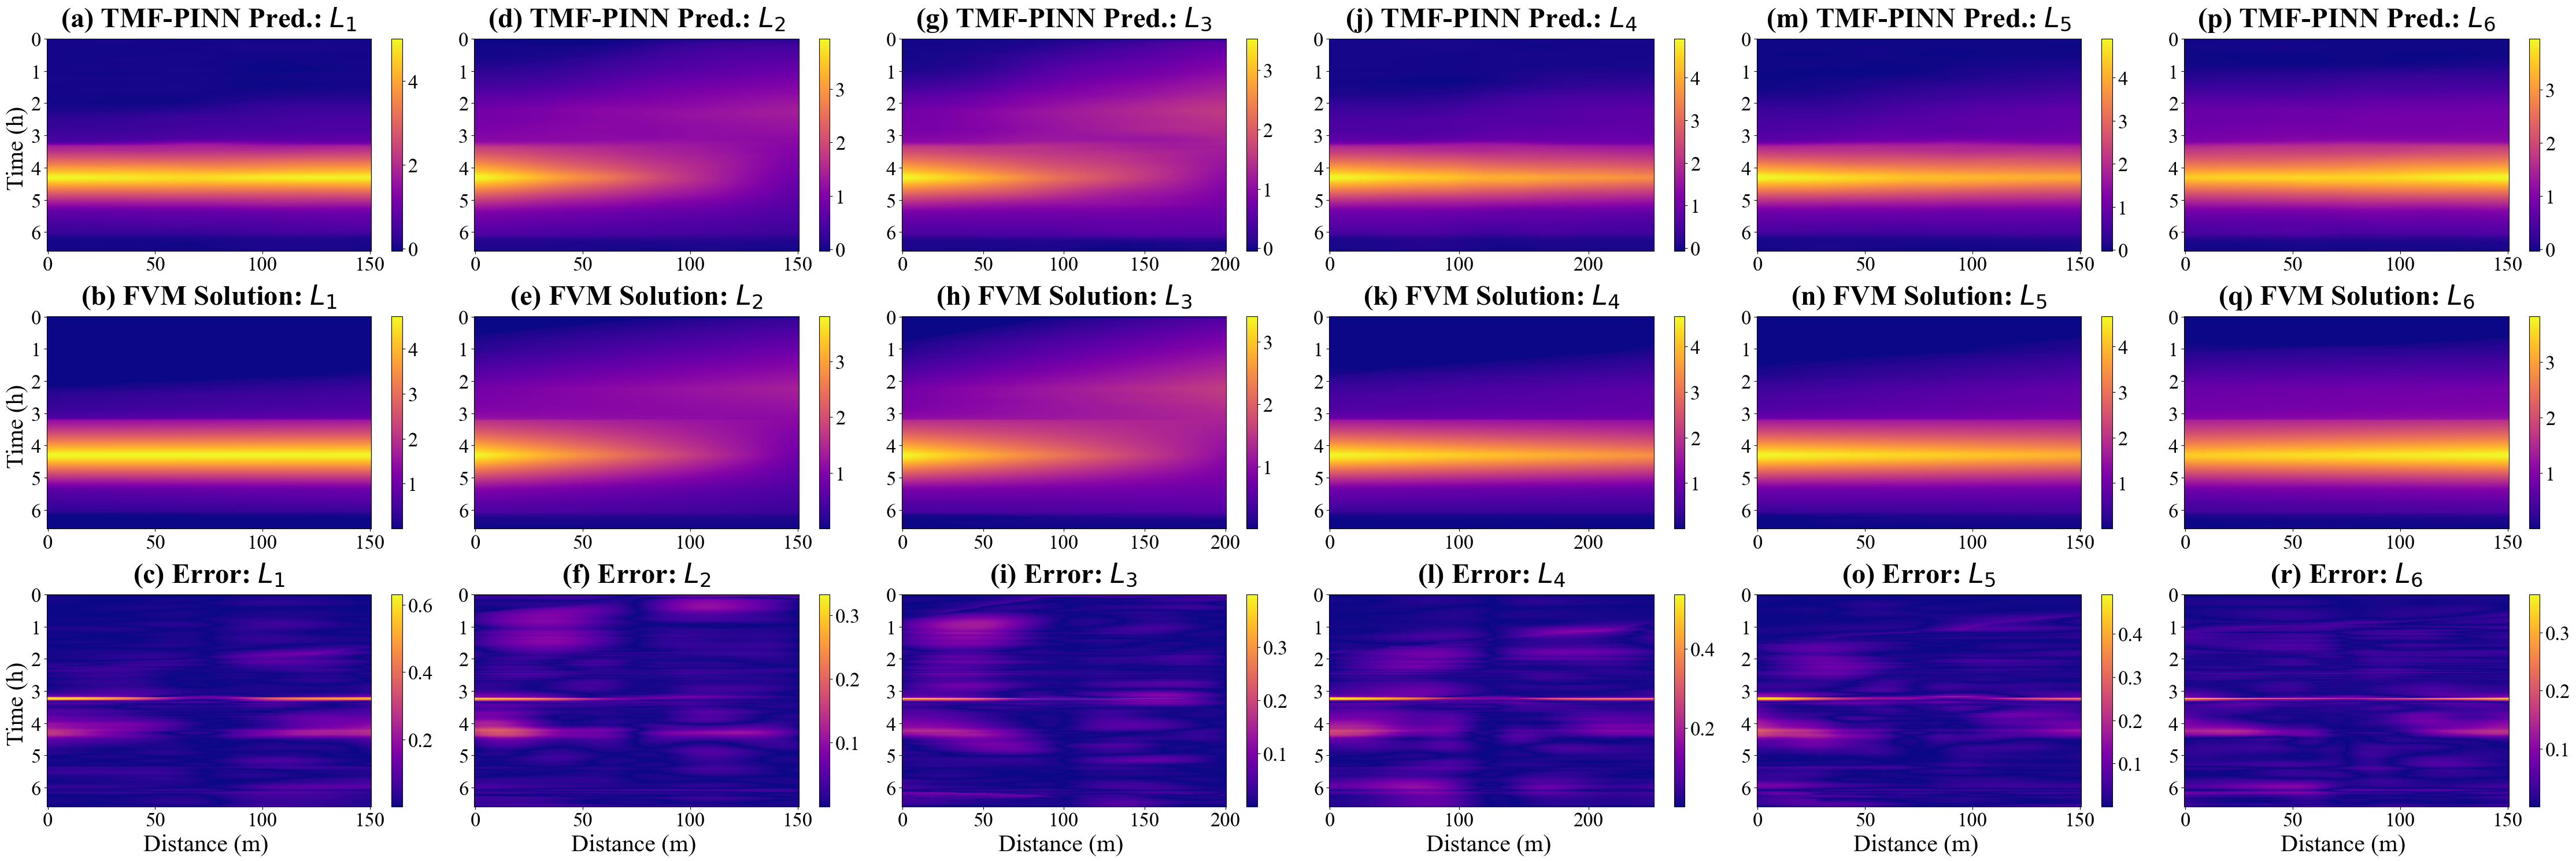

In [4]:
fig, axs = plt.subplots(3, 6, figsize=(45, 15))

variables = [('height (m) ', h_pred2[0][k], h_test[0][k]) for k in range(6)]

labels = [f'($L_{{{k}}}$:{"abc"[i]})' for k in range(1, 7) for i in range(3)]

for j, (variable, pred, test) in enumerate(variables):
    titles = [f'TMF-PINN Pred.', f'FVM Solution', f'Error']
    images = [pred, test, np.abs(test - pred)]
    for i, ax in enumerate(axs[:, j]):
        im = ax.imshow(images[i], aspect='auto', cmap='plasma')  # 设置图像为正方形
        ax.set_title(f'({chr(ord("a") + i + j * 3)}) {titles[i]}: $L_{j+1}$', fontsize=35, fontweight='bold',pad=15,loc='center')  # 将标题放在底部，并以“(a) xxx”格式命名
        cbar = plt.colorbar(im, ax=ax, orientation='vertical')
        cbar.ax.tick_params(labelsize=25)

        if i == 2:  # 在最后一次迭代时设置 x 轴和 y 轴的标签
            ax.set_xlabel('Distance (m) ',fontsize=30)
        if j == 0:  # 在最右边的子图中设置 y 轴的标签
            ax.set_ylabel('Time (h) ',fontsize=30)

        ax.tick_params(axis='x', labelsize=25)  # 设置 x 刻度的字体大小为 30
        ax.set_yticks([0, 100, 200, 300, 400, 500, 600], [0, 1, 2, 3, 4, 5, 6], fontsize=25)
        #ax.text(0.05, 0.05, labels[i + j * 3], transform=ax.transAxes, fontsize=22, weight='bold', color='white')

plt.tight_layout()

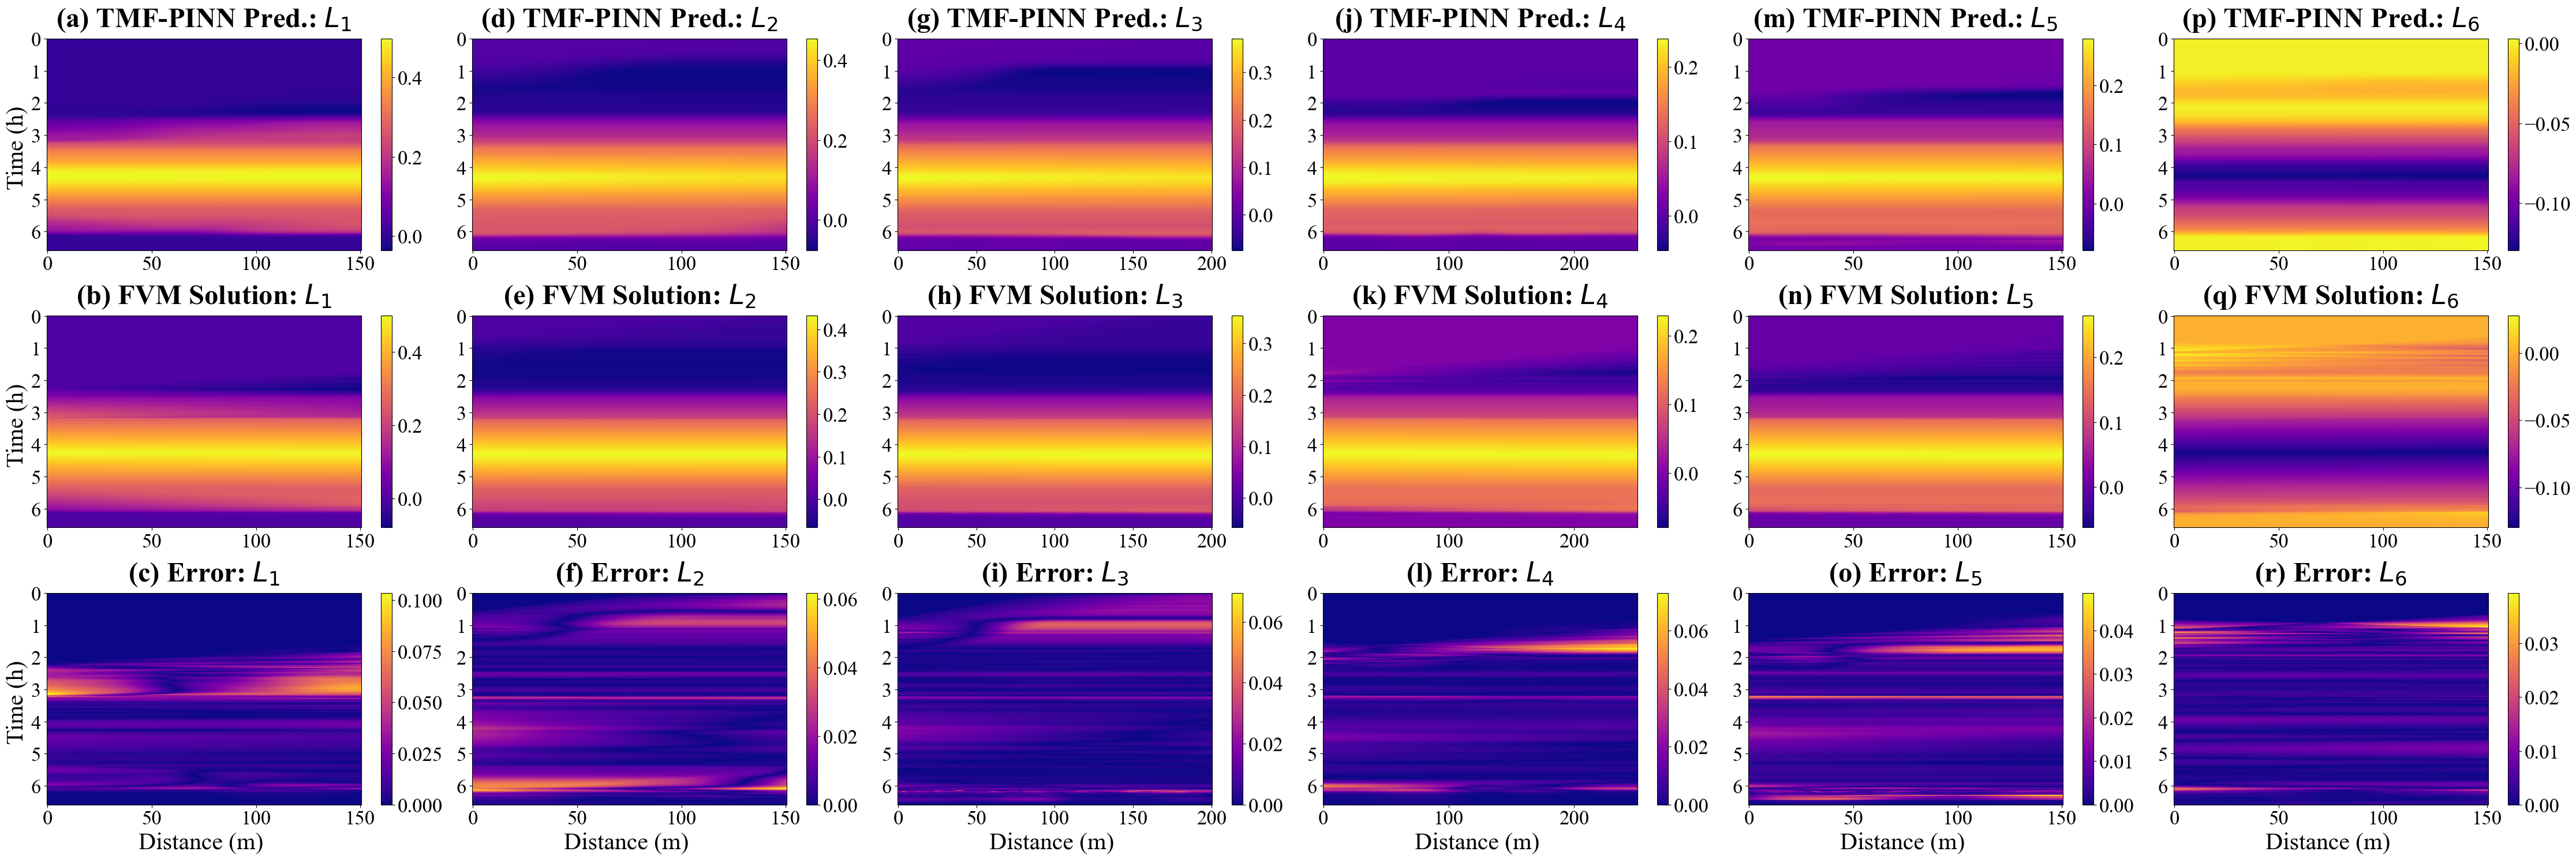

In [5]:
fig, axs = plt.subplots(3, 6, figsize=(45, 15))

variables = [('flowrate (cms)', q_pred2[0][k], q_test[0][k]) for k in range(6)]

labels = [f'($L_{{{k}}}$:{"abc"[i]})' for k in range(1, 7) for i in range(3)]

for j, (variable, pred, test) in enumerate(variables):
    titles = [f'TMF-PINN Pred.', f'FVM Solution', f'Error']
    images = [pred, test, np.abs(test - pred)]
    for i, ax in enumerate(axs[:, j]):
        im = ax.imshow(images[i], aspect='auto', cmap='plasma')  # 设置图像为正方形
        ax.set_title(f'({chr(ord("a") + i + j * 3)}) {titles[i]}: $L_{j+1}$', fontsize=35,fontweight='bold', pad=15,loc='center')  # 将标题放在底部，并以“(a) xxx”格式命名
        cbar = plt.colorbar(im, ax=ax, orientation='vertical')
        cbar.ax.tick_params(labelsize=25)

        if i == 2:  # 在最后一次迭代时设置 x 轴和 y 轴的标签
            ax.set_xlabel('Distance (m) ',fontsize=30)
        if j == 0:  # 在最右边的子图中设置 y 轴的标签
            ax.set_ylabel('Time (h) ',fontsize=30)

        ax.tick_params(axis='x', labelsize=25)  # 设置 x 刻度的字体大小为 30
        ax.set_yticks([0, 100, 200, 300, 400, 500, 600], [0, 1, 2, 3, 4, 5, 6], fontsize=25)
        #ax.text(0.05, 0.05, labels[i + j * 3], transform=ax.transAxes, fontsize=22, weight='bold', color='white')

plt.tight_layout()

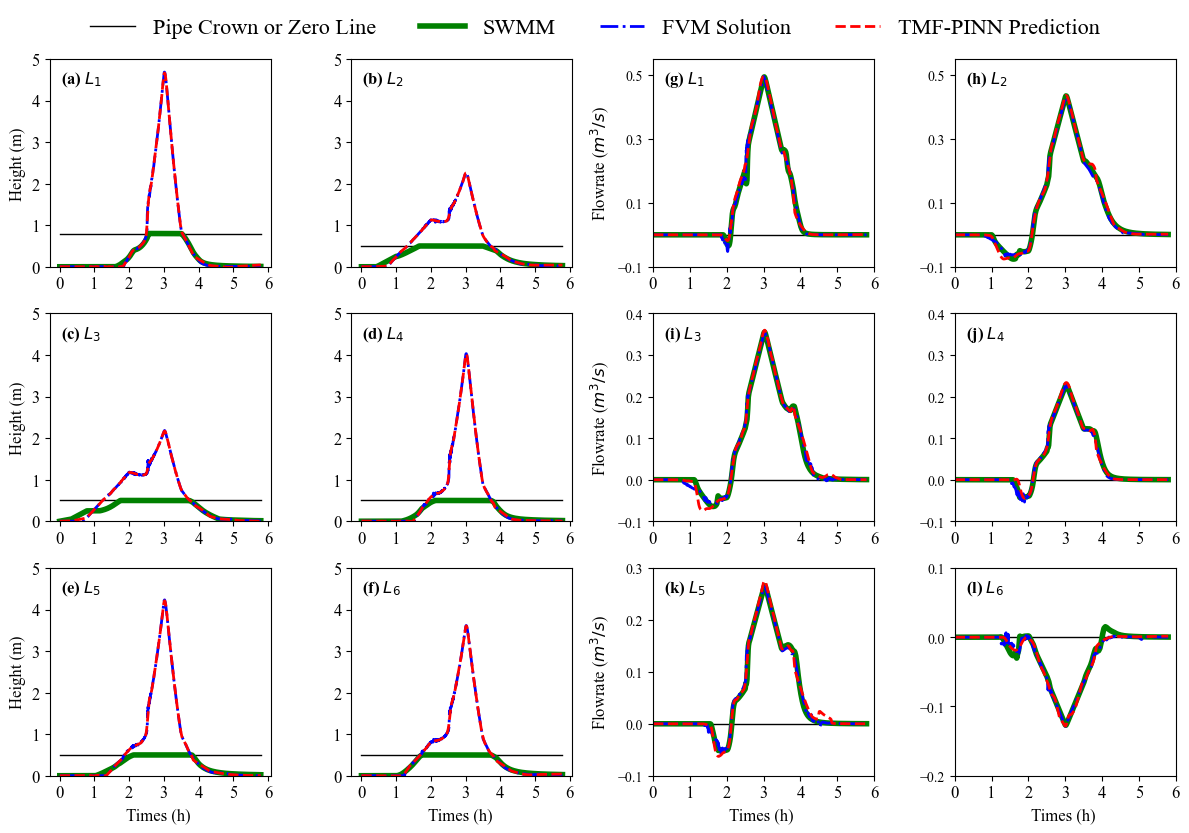

In [6]:
# 创建一个大图，并设置大小
fig = plt.figure(figsize=(12, 8))  # 加宽以容纳两列图
keys1 = [f'({chr(ord("a") + i)}) $L_{i+1}$' for i in range(6)]
keys2 = [f'({chr(ord("g") + i)}) $L_{i+1}$' for i in range(6)]

index=[1,2,5,6,9,10,3,4,7,8,11,12]
# 绘制压力图
for i in range(6):
    mid = int(np.floor(h_test[0][i].shape[1] / 2))
    # 前三行两列用于压力
    ax = plt.subplot(3, 4, index[i])  
    plt.plot(timeFVM[i], D[i]*np.ones_like(hhhobs[0][i]), label='Pipe Crown or Zero Line', c='k', linewidth=1, linestyle='-')
    plt.plot(timeFVM[i], hhhobs[0][i], label='SWMM', c='g', linewidth=4, linestyle='-')
    plt.plot(timeFVM[i], h_test[0][i][:, mid], label='FVM Solution', c='b', linewidth=2, linestyle='-.')
    plt.plot(timeFVM[i], h_pred2[0][i][:, mid], label='TMF-PINN Prediction', c='r', linewidth=2, linestyle='--')
    if i %2==0: 
        plt.ylabel('Height (m)',fontsize=12)
    
    if i==4 or i==5:
        plt.xlabel('Times (h) ',fontsize=12)

    ax.set_xticks([0,1/6*21600,2/6*21600,3/6*21600,4/6*21600,5/6*21600,21600],[0,1,2,3,4,5,6],fontsize=12)
    ax.set_ylim([0,5.0]) 
    #axh.set_xlim([0,21600.0])
    plt.yticks(fontsize=12)
    ax.text(0.05, 0.95, keys1[i], transform=ax.transAxes, fontsize=12, fontweight='bold', ha='left', va='top')

# 绘制流量图
for i in range(6):
    mid = int(np.floor(h_test[0][i].shape[1] / 2))
    # 接下来三行两列用于流量，因此索引需要加 6
    ax = plt.subplot(3, 4, index[i+6]) 
     
    plt.plot(timeFVM[i], np.zeros_like(hhhobs[0][i]), label='Zero Line', c='k', linewidth=1, linestyle='-')
    plt.plot(timeFVM[i], qqqobs[0][i], label='SWMM', c='g', linewidth=4, linestyle='-')
    plt.plot(timeFVM[i], q_test[0][i][:, mid], label='FVM Solution', c='b', linewidth=2, linestyle='-.')
    plt.plot(timeFVM[i], q_pred2[0][i][:, mid], label='TMF-PINN Prediction', c='r', linewidth=2, linestyle='--')
    if i %2==0: 
        plt.ylabel('Flowrate ($m^{3}/s$)',fontsize=12)
    
    if i==4 or i==5:
        plt.xlabel('Times (h) ',fontsize=12)

    
    ax.set_xticks([0,1/6*21600,2/6*21600,3/6*21600,4/6*21600,5/6*21600,21600],[0,1,2,3,4,5,6],fontsize=12)
    ax.set_xlim([0,21600.0])

    if i==5:
        ax.set_ylim([-0.2,0.1]) 
        ax.set_yticks([-0.2,-0.1,0,0.1])
    elif i==0 or i==1:
        ax.set_ylim([-0.1,0.55]) 
        ax.set_yticks([-0.1,0.1,0.3,0.5])
    elif i==2 or i==3:
        ax.set_ylim([-0.1,0.4]) 
        ax.set_yticks([-0.1,0,0.1,0.2,0.3,0.4])
    else:
        ax.set_ylim([-0.1,0.3]) 
        ax.set_yticks([-0.1,0,0.1,0.2,0.3])

    ax.text(0.05, 0.95, keys2[i], transform=ax.transAxes, fontsize=12, fontweight='bold', ha='left', va='top')


fig.tight_layout()
lines, labels = fig.axes[0].get_legend_handles_labels()
fig.legend(lines, labels, loc="upper center", ncol=4, fontsize=16, frameon=False, bbox_to_anchor=(0.5, 1.05))

# plt.savefig('Figure3.jpg', dpi=250, bbox_inches='tight')


# Nodes

In [7]:
node_pred=[]
node_pred.append(h_pred2[0][0][:,0])
node_pred.append(h_pred2[0][1][:,-1])
node_pred.append(h_pred2[0][2][:,-1])
node_pred.append(h_pred2[0][3][:,0])
node_pred.append(h_pred2[0][4][:,-1])
node_pred.append(h_pred2[0][5][:,0])

node_test=[]
node_test.append(h_test[0][0][:,0])
node_test.append(h_test[0][1][:,-1])
node_test.append(h_test[0][2][:,-1])
node_test.append(h_test[0][3][:,0])
node_test.append(h_test[0][4][:,-1])
node_test.append(h_test[0][5][:,0])

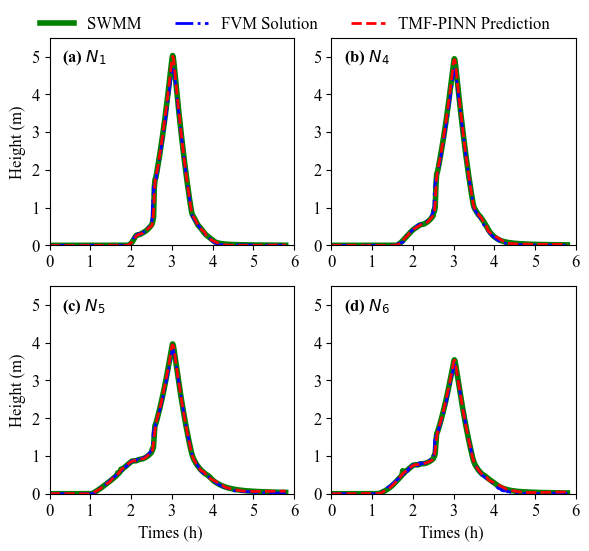

In [8]:
fig1=plt.figure(10, figsize=(6, 8*2/3))
#keys=[f'({chr(ord("a") + i)}) $N_{i+1}$' for i in range(6)]
Node_idx=[0,3,4,5]
keys=[f'({chr(ord("a") + i)}) $N_{idx+1}$' for i,idx in enumerate(Node_idx)]
for i,idx in enumerate(Node_idx):

    mid=int(np.floor(h_test[0][idx].shape[1]/2))

    axh=plt.subplot(2, 2, i+1)  # 1行2列，当前为第1个子图
    
    plt.plot(timeFVM[idx],node_h[idx], label='SWMM',c='g',linewidth=4,linestyle='-')
    plt.plot(timeFVM[idx],node_test[idx], label='FVM Solution',c='b',linewidth=2,linestyle='-.')
    plt.plot(timeFVM[idx],node_pred[idx], label='TMF-PINN Prediction',c='r',linewidth=2,linestyle='--') 
    if idx %2==0: 
        plt.ylabel('Height (m)',fontsize=12)
    
    if idx==4 or idx==5:
        plt.xlabel('Times (h) ',fontsize=12)

    axh.set_xticks([0,1/6*21600,2/6*21600,3/6*21600,4/6*21600,5/6*21600,21600],[0,1,2,3,4,5,6],fontsize=12)
    #axh.set_ylim([0,5.0]) 
    axh.set_xlim([0,21600.0])
    axh.set_ylim([0,5.5])
    plt.yticks(fontsize=12)
    axh.text(0.05, 0.95, keys[i], transform=axh.transAxes,fontsize=12, fontweight='bold', ha='left', va='top')

fig1.tight_layout()
lines, labels = fig1.axes[-2].get_legend_handles_labels()
fig1.legend(lines, labels,loc="upper center",ncol=3,fontsize=12,frameon=False,bbox_to_anchor=(0.5,1.04)) # 图例的位置，bbox_to_anchor=(0.5, 0.92),
#plt.savefig('Figure4.jpg', dpi=250,bbox_inches='tight')#会裁掉多余的白边

In [9]:
kge_all = []

for j in range(3):
    
    # Initialize
    test_combined = np.concatenate([h_test[j][i].flatten() for i in range(6)] + [q_test[j][i].flatten() for i in range(6)])
    pred_combined = np.concatenate([h_pred2[j][i].flatten() for i in range(6)] + [q_pred2[j][i].flatten() for i in range(6)])

    # Combine
    final_kge_all = utils.kge(test_combined, pred_combined)
    # Save
    kge_all.append(final_kge_all)
    # Print "KGE"
    print("Combined KGE", final_kge_all)

Combined KGE 0.9842921000710615
Combined KGE 0.9918849632519564
Combined KGE 0.9196380050310591
